In [215]:
%matplotlib inline
%precision 3

from numpy.random import randn
import numpy as np
import pandas as pd
np.random.seed(123)
import os
import re
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10

import datetime

from numpy import nan as NA

In [2]:
#!powershell -command "& {gc NCDB_1999_to_2014.csv -head 10}"
!powershell -command "& {gc NCDB_1999_to_2014_s.csv -head 10}"

C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
2013,06,2,12,2,02,21,02,1,1,1,01,02,01,2005,01,M,28,11,2,02,1
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,01,F,42,11,1,02,1
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,02,M,04,12,2,01,2
2013,06,2,09,2,01,06,02,1,1,1,18,01,11,2008,03,F,33,98,2,UU,U
2013,06,2,08,2,02,36,02,1,1,3,01,01,01,2005,01,F,44,11,2,02,1
2013,06,2,08,2,02,36,02,1,1,3,01,02,01,2002,01,M,51,11,1,02,1
2013,06,2,11,2,01,06,02,1,1,2,03,01,01,1997,01,M,45,11,1,02,1
2013,06,2,11,2,01,06,02,1,1,2,03,99,NN,NNNN,01,M,19,99,2,13,3
2013,06,2,11,2,01,06,02,1,1,1,01,01,01,2012,01,F,33,11,1,02,1


In [3]:
#accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')
accident = pd.read_csv('NCDB_1999_to_2014_s.csv', engine = 'python')

In [4]:
#replace all column head to lower case.

accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
491547,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [5]:
#check the non-numberic values in date-time columns

accident[accident['c_mnth'].str.contains('[^0-9]')|
         accident['c_wday'].str.contains('[^0-9]')|
         accident['c_hour'].str.contains('[^0-9]')]

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
764,2013,06,2,UU,2,02,21,02,1,1,...,01,01,2009,01,F,53,11,2,02,1
765,2013,06,2,UU,2,02,21,02,1,1,...,02,01,2002,01,F,25,11,1,02,1
839,2013,06,2,UU,1,01,04,UU,1,1,...,01,01,2006,01,M,34,11,3,01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491545,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
491546,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U
491547,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,02,M,10,98,1,01,U


In [32]:
#remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour']]=df[['c_mnth','c_wday','c_hour']].replace('[^0-9]+',np.nan,regex=True)

#df.isnull().sum().sort_values()
df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,2013,06,2,12,2,02,21,02,1,1,...,02,01,2005,01,M,28,11,2,02,1
1,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,01,F,42,11,1,02,1
2,2013,06,2,09,2,01,06,02,1,1,...,01,11,2008,02,M,04,12,2,01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
491522,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2
491523,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,03,F,15,21,2,02,2


In [33]:
#generate the date-time column "date", which could be assigned as index later.
# Caution: the "date

df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'])

#df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')

df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
0,2013,06,2,12,2,02,21,02,1,1,...,01,2005,01,M,28,11,2,02,1,2013-06-01
1,2013,06,2,09,2,01,06,02,1,1,...,11,2008,01,F,42,11,1,02,1,2013-06-01
2,2013,06,2,09,2,01,06,02,1,1,...,11,2008,02,M,04,12,2,01,2,2013-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12-01
491522,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12-01
491523,2014,12,7,19,2,01,03,01,1,3,...,01,2001,03,F,15,21,2,02,2,2014-12-01


In [34]:
# this line use 'date' as index, meke 'df' becoming time series.

#df = df.set_index('date')
#df

In [35]:
# this code to check how many missing values.

# df.isnull().sum().sort_values()


In [209]:
# this code to check detail of missing values.

# df[df['c_vehs'].isnull()]


,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
31258,2013,07,3,16,2,NaN,QQ,01,1,1,...,NN,NNNN,01,M,19,99,2,NN,3,2013-07-01
31259,2013,07,3,16,2,NaN,QQ,01,1,1,...,NN,NNNN,02,M,18,99,1,NN,3,2013-07-01
132090,2013,10,6,15,2,NaN,QQ,UU,1,Q,...,NN,NNNN,01,M,54,99,2,NN,3,2013-10-01


#### Proposed analytics for each selected category:
1. Category statistics (max, min, mean, etc.)
2. Trend over the whole period (increase, decrease, fluky)
3. Correlation between selected category and one or multiple other categories (as per table below)
The result of analysis for all selected categories will contribute to our recommendations in the conclusion. 
P.S.: We don't need to analyse all categories.

|Correlation combination|Collision date (day of week, hour)|Collision severity|Number of vehicles involved in collision|Collision configuration|Weather condition|Vehicle type|
|:--|:--|:--|:--|:--|:--|:--|
|Road alignment|R|R|R|R|-|-|
|Vehicle type|R|R|R|R|R|-|
|Vehicle model year|R|R|R|R|R|R|


### 1 Road Alignment
### 1.1) Road Alignment & Time relation

In [37]:
# slice the columns I would analyse from original dataset.

dfa = df.loc[:,['date','c_year','c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','c_wthr','c_raln','v_type','v_year']]
dfa

,date,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_wthr,c_raln,v_type,v_year
0,2013-06-01,2013,06,2,12,2,02,21,1,1,01,2005
1,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
2,2013-06-01,2013,06,2,09,2,01,06,1,1,11,2008
...,...,...,...,...,...,...,...,...,...,...,...,...
491521,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001
491522,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001
491523,2014-12-01,2014,12,7,19,2,01,03,1,4,01,2001


In [38]:
#check how many unknown in road alignment.

dfa['c_raln'].value_counts().sort_index()

1    360937
2     42704
3     28025
      ...  
6      4541
Q       932
U     29119
Name: c_raln, Length: 8, dtype: int64

In [101]:
# Make a slice only focusing on c_raln: road alignment.

df1 = dfa.loc[:,['date','c_raln']]

#Agregate the events by month into a summarized dataframe.
df2 = df1.groupby(['date','c_raln']).size().unstack()
df2

c_raln,1,2,3,4,5,6,Q,U
date,,,,,,,,
2013-06-01,15668,1867,1198,644,235,165,43,1495
2013-07-01,21836,2601,1502,825,348,260,58,1739
2013-08-01,21878,2607,1661,953,316,240,51,1786
...,...,...,...,...,...,...,...,...
2014-10-01,20778,2366,1319,780,214,206,65,1569
2014-11-01,19351,2400,1574,1053,385,276,40,1546
2014-12-01,18561,2120,1700,992,330,251,25,1425


In [102]:
# df1.groupby(['date','c_raln']).size().sort_values()
# df1.groupby(['date','c_raln']).size().unstack()

#df2 = df1.groupby(['date','c_raln']).size().unstack()

#df2

# df2.iloc[:,0].sum()
#df2.resample('M').sum().iloc[:,0].sum()
#df2 = df2.resample('M').sum()


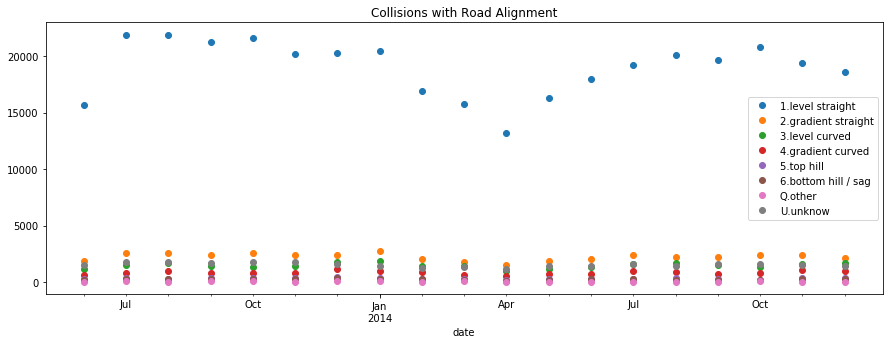

In [100]:
# Plot the dataframe into graph to visulize the result.

c_raln=['1.level straight','2.gradient straight',
           '3.level curved','4.gradient curved',
           '5.top hill','6.bottom hill / sag',
           'Q.other','U.unknow']

df2.plot(style = 'o', figsize = (15,5), title = 'Collisions with Road Alignment')
plt.legend(c_raln);


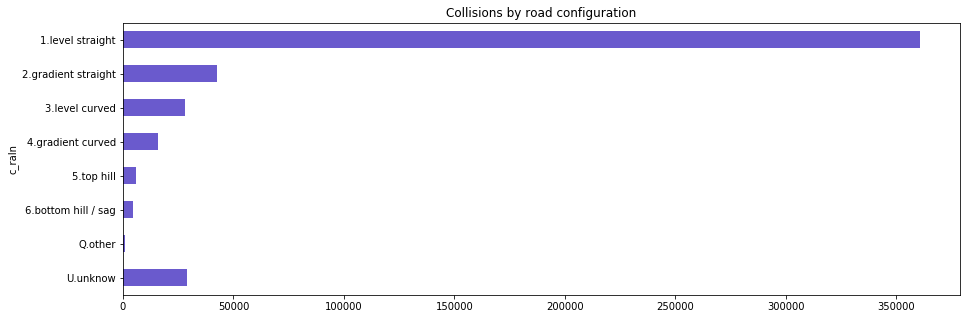

In [99]:
df3=df1.groupby('c_raln').size().sort_index(ascending=False)

df3.plot.barh(color='slateblue',figsize=(15,5),title='Collisions by road configuration')
plt.yticks(np.arange(0,8),c_raln[::-1]);


#### Conlusion: most collisions happened on level and straight road, reason could be the vehicle of high speed, and driver not paying enough attention given the good road condition

### 1.2) Road Alignment & Collision severity


In [171]:
#Use a new dataframe to analyze the relationship between Severity and Road Alignment.
#For C_Sev, 1 is fatal, and 2 is non-fatal.

df1 = dfa.loc[:,['c_raln','c_sev']]
df4 = df1.groupby(['c_raln','c_sev']).size().unstack()

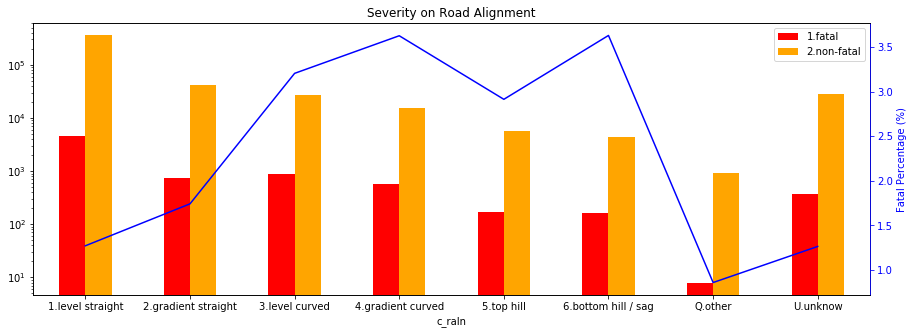

In [170]:
#Plot the relationship between Severity and Road Alignment.

#Create a twin y-axis plot area, and define axis parameters.
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.
df4.plot(kind='bar',rot=0,logy=True,color=['red','orange'],figsize=(15,5),title='Severity on Road Alignment', ax=ax1)

#Calculate the percentage of fatal injury in all accidents by different road alignment, and plot to right axis.
se1 = df4[1]/(df4[1]+df4[2])*100
se1.plot(color='b', ax=ax2)

plt.xticks(np.arange(0,8),c_raln)
ax1.legend(['1.fatal','2.non-fatal']);


#### Conclusion: fatal injury represent a very small portion of all accident (less than 4% in any given cases).  It's also obvious that the level-straight road has less fatal injury, though the total number is much more than other cases; instead, the uneven condition (curved and noncurved) may produce severe accident.  This could be caused by limited sight.

### 1.3) Road Alignment & Number of vehicles involved in collision


In [327]:
df1 = dfa.loc[:,['c_raln','c_vehs']]
df1.c_vehs.replace('UU',np.nan, inplace=True)
df1.dropna(inplace=True)
df1.c_vehs=df1.c_vehs.astype(int)
df1.c_vehs.value_counts().sort_index()

#Calculate accident portion of each event, considering 58 records that have 57 vehicle involved, that should be just one accident,
# every relevant record should be only about 1/57.
df1['acc']= 1/df1.c_vehs

#Categorize number of involved vehicles into bins.
bins = [0,5,10,20,40,60]
df1['cats'] = pd.cut(df1.c_vehs,bins)

#Summarize the collisions on road alignment and number of involved vehicles.
df5 = df1.groupby(['cats','c_raln'])['acc'].sum().unstack()
df5.dropna(how='all', inplace=True)
df5.fillna(0, inplace=True)
df5

c_raln,1,2,3,4,5,6,Q,U
cats,,,,,,,,
"(0, 5]",200280.016667,23754.316667,19718.716667,11293.383333,3582.500000,2866.3,616.250000,16391.350000
"(5, 10]",261.703968,54.810714,12.793651,11.959524,2.500000,1.0,2.416667,5.666667
"(10, 20]",34.003238,3.458556,2.511765,5.333333,1.533333,0.0,0.000000,1.083333
"(20, 40]",9.044228,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
"(40, 60]",1.023256,1.017544,1.568627,0.000000,0.000000,0.0,0.000000,0.000000


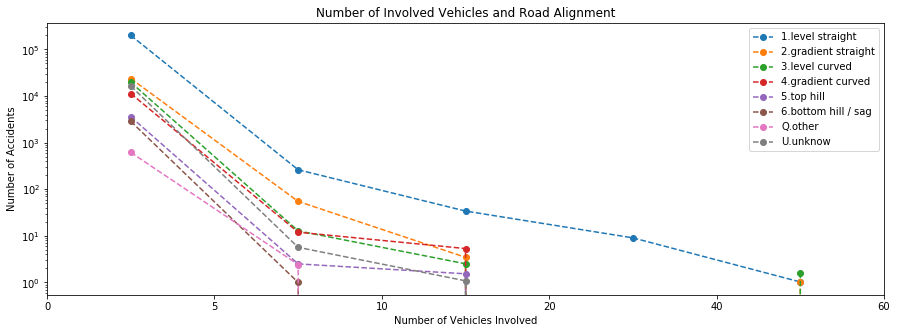

In [328]:
#Plot the result.

df5.plot(logy=True,figsize=(15,5),style='o--',title='Number of Involved Vehicles and Road Alignment')
plt.xticks(np.arange(-0.5,5.5),bins)
plt.xlabel('Number of Vehicles Involved')
plt.ylabel('Number of Accidents')
plt.legend(c_raln);

#### Conclution: Majority accident are involving less than 5 cars.  As the plots are very similar for different road alignments, no specific relationship observed between the two varibles.

### 1.4) Road Alignment & Collision Configuration